In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder, RobustScaler, Normalizer
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, label_ranking_loss, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
test_targets = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [4]:
#quick look at our data types & null counts 
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


In [5]:
# To better understand the numeric data, we want to use the .describe() method. 
# This gives us an understanding of the central tendencies of the data. 

train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [6]:
# Reading the train dataset
train_features.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


In [7]:
# Reading the test dataset 
test_features.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.384,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942


In [8]:
# To calculate the rows and columns in the dataset
print('The Training dataset has {} rows and {} columns.'.format(len(train_features), len(train_features.columns)))

The Training dataset has 23814 rows and 876 columns.


In [9]:
print('The Test dataset has {} rows and {} columns.'.format(len(test_features), len(test_features.columns)))

The Test dataset has 3982 rows and 876 columns.


## categorical data in the dataset

Text(0.5, 0.98, 'Distribution in Train dataset of Type, Time and Dose')

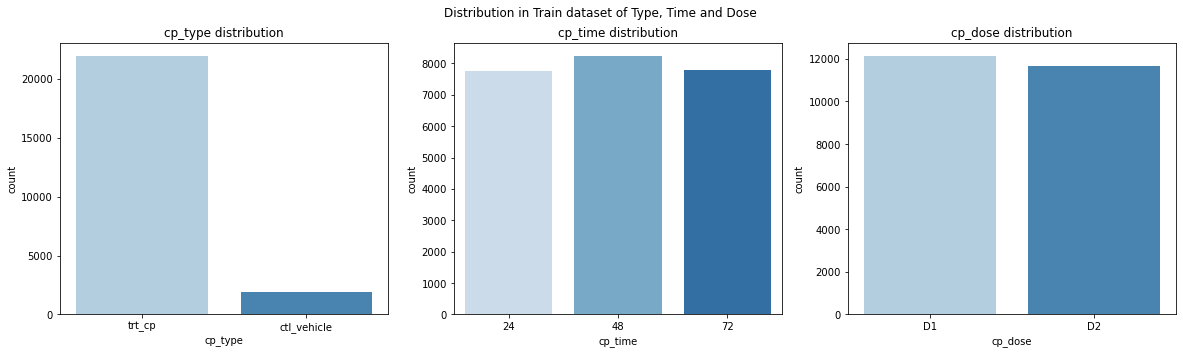

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


sns.countplot(train_features['cp_type'],palette=("Blues"), ax=ax[0])
ax[0].set_title('cp_type distribution')

sns.countplot(train_features['cp_time'],palette=("Blues"), ax=ax[1])
ax[1].set_title('cp_time distribution')

sns.countplot(train_features['cp_dose'],palette=("Blues"), ax=ax[2])
ax[2].set_title('cp_dose distribution')

fig.suptitle('Distribution in Train dataset of Type, Time and Dose')

Text(0.5, 0.98, 'Distribution in Test dataset of Type, Time and Dose')

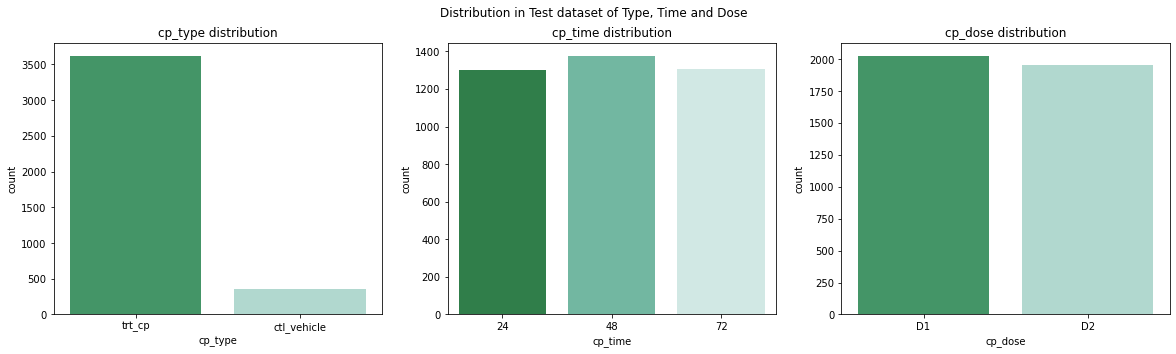

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))


sns.countplot(test_features['cp_type'],palette=("BuGn_r"), ax=ax[0])
ax[0].set_title('cp_type distribution')

sns.countplot(test_features['cp_time'],palette=("BuGn_r"), ax=ax[1])
ax[1].set_title('cp_time distribution')

sns.countplot(test_features['cp_dose'],palette=("BuGn_r"), ax=ax[2])
ax[2].set_title('cp_dose distribution')

fig.suptitle('Distribution in Test dataset of Type, Time and Dose')

In [12]:
train_features['cp_type'] = train_features['cp_type'].astype('category')
train_features['cp_type'].cat.categories = [0, 1]
train_features['cp_type'] = train_features['cp_type'].astype("int")

In [13]:
train_features['cp_dose'] = train_features['cp_dose'].astype('category')
train_features['cp_dose'].cat.categories = [0, 1]
train_features['cp_dose'] = train_features['cp_dose'].astype("int")

In [14]:
train_features['cp_time'] = train_features['cp_time'].astype('category')
train_features['cp_time'].cat.categories = [0, 1, 2]
train_features['cp_time'] = train_features['cp_time'].astype("int")

In [15]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


### Numerical value in the dataset

In [16]:
print('Number of "g-" features are: ', len([i for i in train_features.columns if i.startswith('g-')]))
print('Number of "c-" features are: ', len([i for i in train_features.columns if i.startswith('c-')]))

Number of "g-" features are:  772
Number of "c-" features are:  100


* The g- signify gene feature. It's from  g-0 : g-771
* The c- signify cell viability feature, It's from  c-0 : c-99

## Checking the Normal Distribution or Gaussian Distribution in the dataset.

### Gene Feature

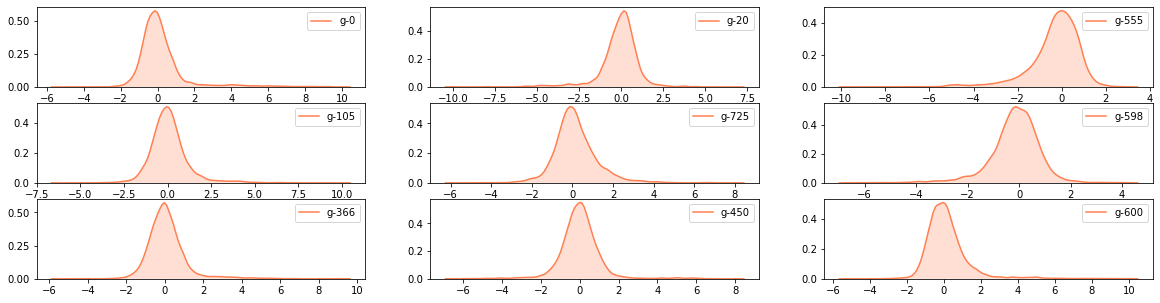

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(20, 5))

sns.kdeplot(test_features['g-0'], shade = True, color = 'coral', ax=ax[0, 0])
sns.kdeplot(test_features['g-20'], shade = True, color = 'coral', ax=ax[0, 1])
sns.kdeplot(test_features['g-555'], shade = True, color = 'coral', ax=ax[0, 2])
sns.kdeplot(test_features['g-105'], shade = True, color = 'coral', ax=ax[1, 0])
sns.kdeplot(test_features['g-725'], shade = True, color = 'coral', ax=ax[1, 1])
sns.kdeplot(test_features['g-598'], shade = True, color = 'coral', ax=ax[1, 2])
sns.kdeplot(test_features['g-366'], shade = True, color = 'coral', ax=ax[2, 0])
sns.kdeplot(test_features['g-450'], shade = True, color = 'coral', ax=ax[2, 1])
sns.kdeplot(test_features['g-600'], shade = True, color = 'coral', ax=ax[2, 2])

### Cell viability features

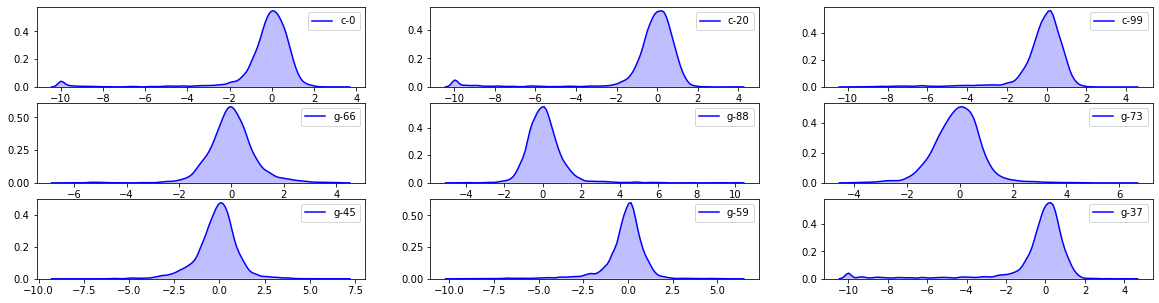

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(20, 5))

sns.kdeplot(test_features['c-0'], shade = True, color = 'blue', ax=ax[0, 0])
sns.kdeplot(test_features['c-20'], shade = True, color = 'blue', ax=ax[0, 1])
sns.kdeplot(test_features['c-99'], shade = True, color = 'blue', ax=ax[0, 2])
sns.kdeplot(test_features['g-66'], shade = True, color = 'blue', ax=ax[1, 0])
sns.kdeplot(test_features['g-88'], shade = True, color = 'blue', ax=ax[1, 1])
sns.kdeplot(test_features['g-73'], shade = True, color = 'blue', ax=ax[1, 2])
sns.kdeplot(test_features['g-45'], shade = True, color = 'blue', ax=ax[2, 0])
sns.kdeplot(test_features['g-59'], shade = True, color = 'blue', ax=ax[2, 1])
sns.kdeplot(test_features['g-37'], shade = True, color = 'blue', ax=ax[2, 2])

* The most case the points are centred around 0 are close to normal distribution.
* In some case we can find skeness in the data

### Mean and standard deviation for gene feature

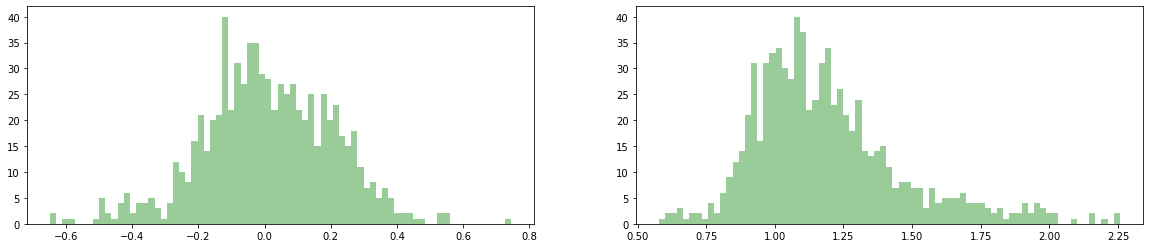

In [19]:
g_cols = [f'g-{i}' for i in range(772)]
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.distplot(train_features[g_cols].mean(), kde=False,color = 'green', bins = 75, ax = ax[0])
sns.distplot(train_features[g_cols].std(), kde=False,color = 'green',  bins = 75, ax = ax[1])

### Mean and standard deviation for Cell viability feature

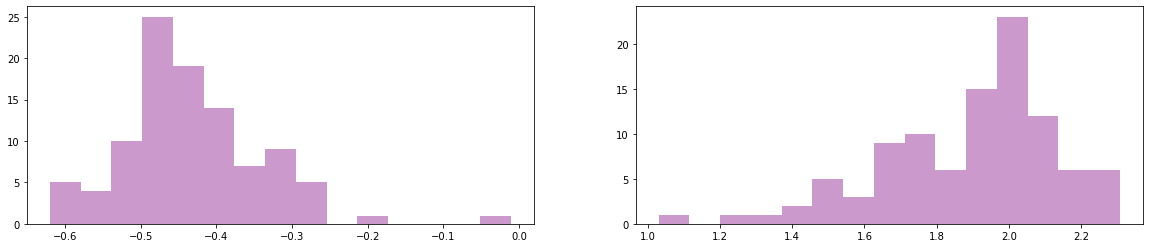

In [20]:
c_cols = [f'c-{i}' for i in range(100)]
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.distplot(train_features[c_cols].mean(), kde=False,color = 'purple', bins = 15, ax = ax[0])
sns.distplot(train_features[c_cols].std(), kde=False,color = 'purple',  bins = 15, ax = ax[1])

### correlation matrix for gene feature 

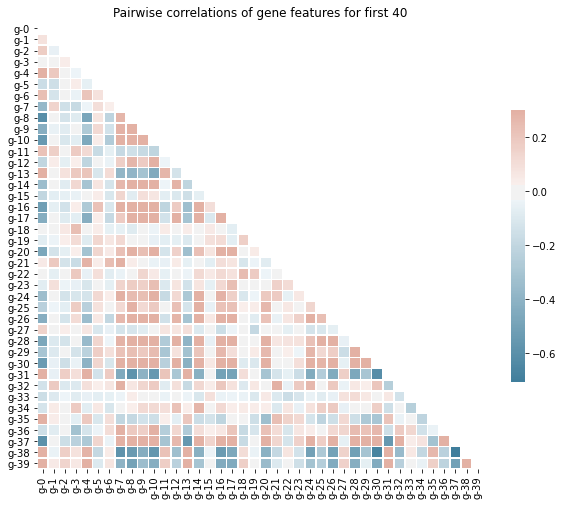

In [21]:
# Compute the correlation matrix
corr = train_features[g_cols[:40]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Pairwise correlations of gene features for first 40')
plt.show()

In this we can see that some of the feature are strongly correlate with each other.

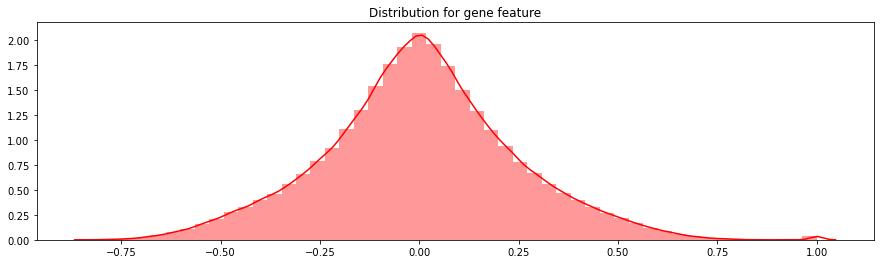

In [22]:
f, ax = plt.subplots(figsize=(15, 4))
sns.distplot(train_features[g_cols].corr(),color='r')
plt.title("Distribution for gene feature")
plt.show()

The correlation of the gene is Normal Distributed or Gaussian Distribution and also we do have some outlayers.

### correlation matrix for cell viability feature

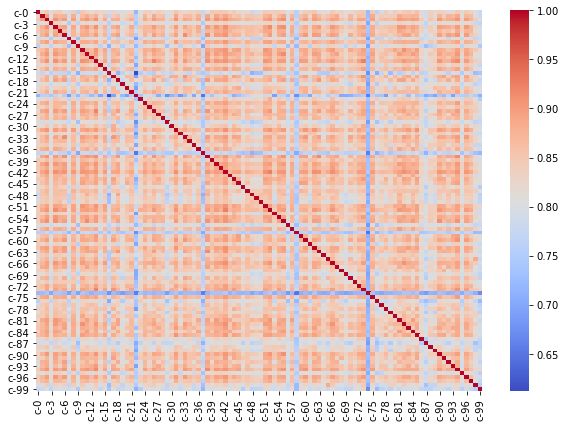

In [23]:
plt.figure(figsize=(10,7))
sns.heatmap(train_features[c_cols].corr(), cmap='coolwarm');

The lowest value is around 0.6, therefore the value are highly correlated

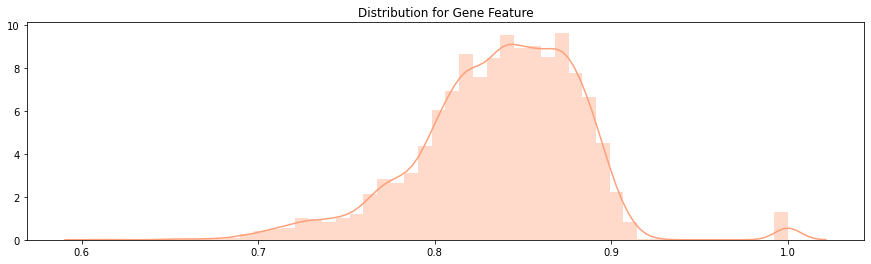

In [24]:
f, ax = plt.subplots(figsize=(15, 4))
sns.distplot(train_features[c_cols].corr(),color='lightsalmon')
plt.title("Distribution for Gene Feature")
plt.show()

In [25]:
train_features_cor = train_features.corr()

In [26]:
train_features_cor.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
cp_type,1.000000,-0.000857,-0.000252,0.072139,0.066868,0.053437,-0.002551,0.091805,-0.013221,-0.092641,...,-0.092025,-0.084773,-0.076649,-0.107095,-0.104947,-0.098305,-0.087668,-0.092418,-0.120323,-0.117060
cp_time,-0.000857,1.000000,-0.001122,0.007610,0.043335,-0.162238,-0.031226,0.027241,-0.081324,-0.030058,...,-0.056778,-0.053159,-0.079995,-0.032101,-0.064898,-0.112583,-0.067116,-0.067969,-0.088916,-0.075736
cp_dose,-0.000252,-0.001122,1.000000,-0.046947,0.101326,-0.097255,0.020745,-0.050323,-0.141974,-0.046977,...,0.021635,0.025650,0.041799,0.029549,0.028690,0.025122,0.026105,0.024246,0.031905,0.026250
g-0,0.072139,0.007610,-0.046947,1.000000,0.086032,0.176188,0.011266,0.403153,-0.165478,0.238348,...,-0.648726,-0.629025,-0.633479,-0.668520,-0.656116,-0.600758,-0.646784,-0.622840,-0.640484,-0.609238
g-1,0.066868,0.043335,0.101326,0.086032,1.000000,-0.054518,-0.027855,0.193647,-0.151590,-0.122541,...,-0.034557,-0.000934,-0.022478,-0.034891,-0.042638,-0.011237,-0.022127,-0.008487,-0.002824,-0.002308


Some feature are most correlated with other feature. To see the multicolinearity of all feature, we are using **Variance Inflation Factor(VIF)**.

In [27]:
vifs = pd.DataFrame(np.linalg.inv(train_features_cor.values).diagonal(), index = train_features_cor.index, columns=['VIF'])

In [28]:
vifs.tail(6)

,VIF
c-94,18.225155
c-95,7.952225
c-96,13.317588
c-97,11.335786
c-98,9.491259
c-99,6.920970


In [29]:
# we take a value where vif is greater than 15.

greater_vifs = vifs.where(vifs>15)
greater_vifs = greater_vifs.dropna()

In [30]:
cols_remove = greater_vifs.index

In [31]:
cols_remove 
# This is a feature that have highly correlated with any number of the other variables.

Index(['g-37', 'g-50', 'g-75', 'g-744', 'c-2', 'c-4', 'c-6', 'c-10', 'c-13',
       'c-17', 'c-18', 'c-26', 'c-31', 'c-33', 'c-38', 'c-42', 'c-51', 'c-52',
       'c-55', 'c-60', 'c-62', 'c-63', 'c-66', 'c-70', 'c-73', 'c-81', 'c-82',
       'c-83', 'c-90', 'c-94'],
      dtype='object')

In [32]:
new_train_features_data = train_features.drop(columns=cols_remove) # we drop these columns highly correlated

In [33]:
new_train_features_data.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-88,c-89,c-91,c-92,c-93,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-1.0120,0.6685,0.2584,0.8076,0.5523,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4236,0.3192,0.7543,0.4708,0.0230,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0.3019,-0.0873,-0.6297,0.6103,0.0223,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-1.5550,0.2431,-0.6441,-5.6300,-1.3780,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.6054,-0.1824,0.0048,0.6670,1.0690,-0.3031,0.1094,0.2885,-0.3786,0.7125


### Test Features

In [34]:
test_features['cp_type'] = test_features['cp_type'].astype('category')
test_features['cp_type'].cat.categories = [0, 1]
test_features['cp_type'] = test_features['cp_type'].astype("int")

In [35]:
test_features['cp_dose'] = test_features['cp_dose'].astype('category')
test_features['cp_dose'].cat.categories = [0, 1]
test_features['cp_dose'] = test_features['cp_dose'].astype("int")

In [36]:
test_features['cp_time'] = test_features['cp_time'].astype('category')
test_features['cp_time'].cat.categories = [0, 1, 2]
test_features['cp_time'] = test_features['cp_time'].astype("int")

In [37]:
test_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,1,0,0,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,1,2,0,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,0,0,0,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,1,0,1,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,1,1,0,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


# Targets

In [38]:
targets = train_targets_scored

In [39]:
targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
print('The Tergets dataset has {} rows and {} columns.'.format(len(targets), len(targets.columns)))

The Tergets dataset has 23814 rows and 207 columns.


In [41]:
target_cols = targets.columns[1:]

Top 20 most frequent targets.

In [42]:
targets_fre = (targets[target_cols].mean() * 100).sort_values()[-20:].index

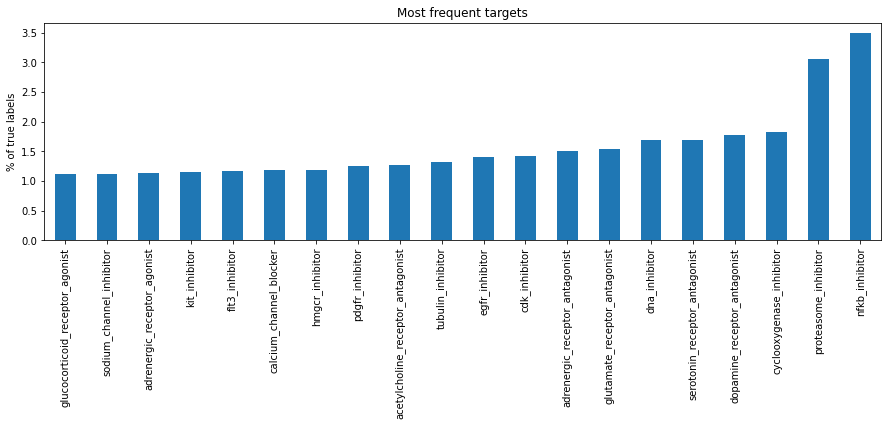

In [43]:
plt.figure(figsize=(15,4))
(targets[targets_fre].mean() * 100).sort_values().plot.bar()
plt.title('Most frequent targets')
plt.ylabel('% of true labels')
plt.show()

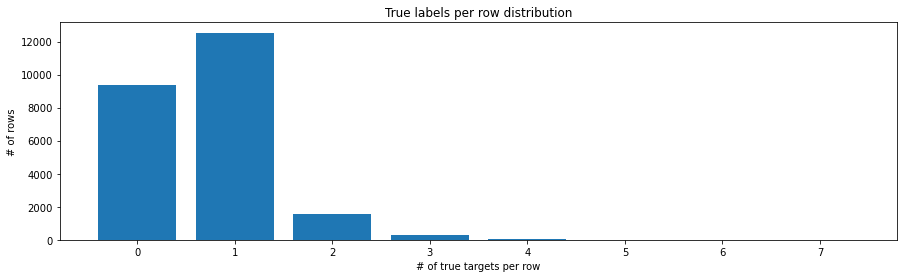

In [44]:
plt.figure(figsize=(15,4))
vc = targets[target_cols].sum(axis=1).value_counts()
plt.title('True labels per row distribution')
plt.ylabel('# of rows')
plt.xlabel('# of true targets per row')
plt.bar(vc.index, vc.values)
plt.show()

In [45]:
train_targets_scored.drop(['sig_id'], axis=1, inplace=True)

In [46]:
train_targets_scored.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
test_ids = test_features['sig_id']

In [48]:
for d in [new_train_features_data, test_features]:
    d.drop(['sig_id','cp_type', 'cp_dose', 'cp_time'], axis=1, inplace=True)
    
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Model Building

In [49]:
x_train, x_cv, y_train, y_cv = train_test_split(new_train_features_data, train_targets_scored, test_size=0.2) 

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, input_dim=x_train.shape[1], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               431616    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1

In [51]:
factor= 0.8250037987063858
patience=2
min_lr= 5.101088055532695e-05
lr=6.353131263848553e-05
batch_size=353
epochs=359

def callbacks(file_path):
    reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=factor,
                                         patience=patience,
                                         cooldown=1,
                                         min_lr=min_lr,
                                         verbose=1)
    checkpoint = ModelCheckpoint(filepath = file_path,monitor='val_loss',
                                 mode='min',save_best_only=True,verbose=1)

    early = EarlyStopping(monitor="val_loss", mode="min", patience= patience)

    return [reduce_learning_rate,checkpoint,early]

file_path = model.name+'best_weights.hd5'
callbacks_list = callbacks(file_path = file_path)

optimizer = tf.keras.optimizers.Adam(lr=lr, amsgrad=True)
#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer)

history=model.fit(x_train,y_train,epochs= epochs, batch_size=batch_size, callbacks = callbacks_list)

Epoch 1/359
54/54 [==============================] - 5s 84ms/step - loss: 0.8402
Epoch 2/359
54/54 [==============================] - 4s 80ms/step - loss: 0.7676
Epoch 3/359
54/54 [==============================] - 4s 80ms/step - loss: 0.7360
Epoch 4/359
54/54 [==============================] - 4s 80ms/step - loss: 0.7203
Epoch 5/359
54/54 [==============================] - 4s 78ms/step - loss: 0.7055
Epoch 6/359
54/54 [==============================] - 4s 80ms/step - loss: 0.6894
Epoch 7/359
54/54 [==============================] - 5s 88ms/step - loss: 0.6692
Epoch 8/359
54/54 [==============================] - 5s 85ms/step - loss: 0.6435
Epoch 9/359
54/54 [==============================] - 4s 81ms/step - loss: 0.6126
Epoch 10/359
54/54 [==============================] - 4s 81ms/step - loss: 0.5767
Epoch 11/359
54/54 [==============================] - 4s 80ms/step - loss: 0.5371
Epoch 12/359
54/54 [==============================] - 4s 78ms/step - loss: 0.4946
Epoch 13/359
54/54 [=====

In [52]:
(test_targets[pd.read_csv('../input/lish-moa/sample_submission.csv').columns]).to_csv('submission.csv',index=False)